## Importing Primary Libraries

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
%matplotlib inline

### Fetching MINST data...

In [3]:
mnist = fetch_openml('mnist_784', version=1)

### MNIST data is in the form of a python dictionary, from which we can access its various `keys()`

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### Defining the 'X' and 'y' for ML processing

In [5]:
X, y = mnist["data"], mnist["target"]

### Checking the shapes

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

### Visualizing a single entry with matplotlib's `imshow()` function with some pre-processing

In [8]:
some_digit = X.iloc[5]
some_digit_image = some_digit.values.reshape(28, 28)

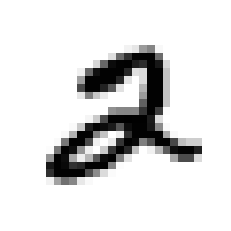

In [9]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

### Converting the 'y' to `int` type from `str`

In [10]:
y = y.astype(np.uint8)

### Spliting data into 'train' and 'test' sets

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a binary classifier
#### For simplicity purpose we can try to identify only one digit(5) and this '5-detector' will be a binary classifier

In [12]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)
y_train_5.head()

0     True
1    False
2    False
3    False
4    False
Name: class, dtype: bool

#### Using Stochastic Gradient Descent(SGD) classifier as it capable of handling a very large datasets efficiently because SGD deals with training instances independently, one at a time

In [13]:
from sklearn.linear_model import SGDClassifier


In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

#### Checking the classifier's prediction on 'some_digit'

In [15]:
sgd_clf.predict([some_digit])

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([False])

### Measuring Accuracy using Cross Validation method `cross_val_score()`
In this method K-fold cross-validation will split the training set in 3 folds, then will make predictions and evaluate them on each fold using a model trained on remaining folds.

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### Trying to predict using a dumb classifier 

In [18]:
from sklearn.base import BaseEstimator

In [19]:
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

#### `cross_val_predict` performs K-fold cross-validation just like `cross_val_score` but returns predictions made on each test fold instead of evaluation scores

In [21]:
from sklearn.model_selection import cross_val_predict

In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

### Confusion matrix
It provides a much better way to evaluate the performance of a classifier.

**Confusion Matrix Layout**  
|   True -ve    |   False +ve   |  
|   False -ve   |   True +ve    |

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### How a Perfect Confusion Matrix looks like

In [25]:
y_train_perfect_pred = y_train_5

In [26]:
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Difference between Precision & Recall

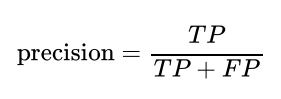


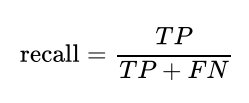  
here, TP-No. of True positives, FP-No. of False positives and TP-No. of False negatives



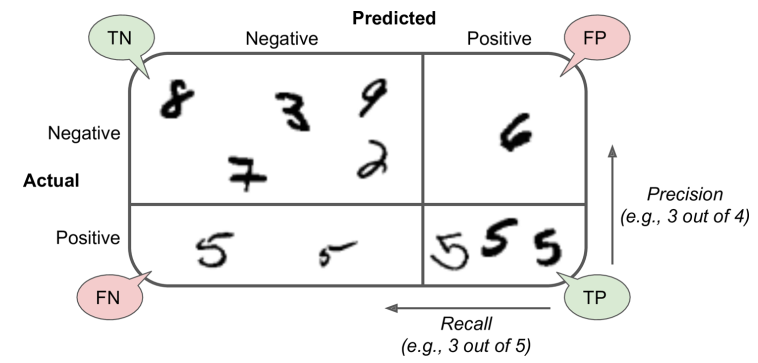

#### increasing precision reduces recall, and vice versa and this is called the **Precision/Recall trade-off**

In [27]:
from sklearn.metrics import precision_score, recall_score

In [28]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

### **F1 score** is the harmonic mean of precision and recall  
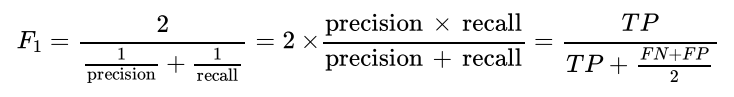

In [30]:
from sklearn.metrics import f1_score

In [31]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### `decision function` depends on the decision threshold of the classifier(here SGDClassifier)
it returns a score for each instance

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([-3908.27576291])

#### SGDClassifier uses a threshold of 0, which is proved by the previous identical results 

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### Now how to decide which threshold value to use

1. using `cross_val_predict()` function to get the scores of all instances in the training set and also specifying that to return decision scores instead of predictions

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [35]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

2. using `precision_recall_curve()` function to compute precision and recall for all possible thresholds

In [36]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

3. using `matplotlib` to plot precision and recall as functions of the threshold value

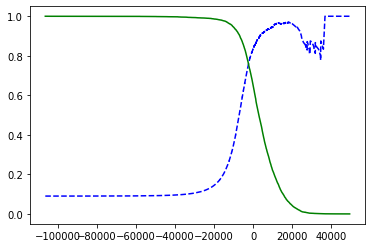

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

4. alternatively, plotting precision directly against recall to select a good precision/recall trade-off

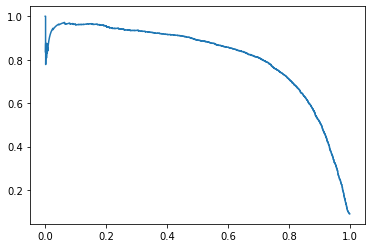

In [38]:
plt.plot(recalls, precisions)

#### `np.argmax()` function searchs for the lowest threshold that gives at least 90% precision  
*  will give the first index of the maximum value, which in this case means the first True value

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
threshold_90_precision

3370.019499143957

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [41]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### Receiver Operating Characteristics(ROC) curve
* used to plot recall/true positive rate(tpr) against false positive rate(fpr)
* fpr = 1 - true negative rate/specificity(tnr)

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot()

* a good classifier stays as far away from that dotted line as possible (toward the top-left corner)

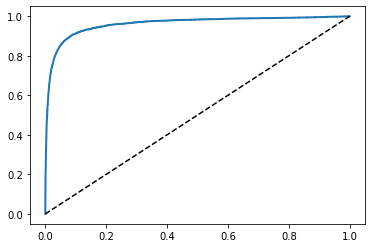

In [45]:
plot_roc_curve(fpr, tpr)

### Area under ROC
*  perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [46]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Using **RandomForestClassifier** to compare its ROC curve and  ROC AUC score against **SGDClassifier**

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

### RandomForestClassifier has `predict_proba()` function instead of `decision_function()`

In [48]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]

#### ROC curve is fed with probabilities in place of labels & scores

In [49]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

#### RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s

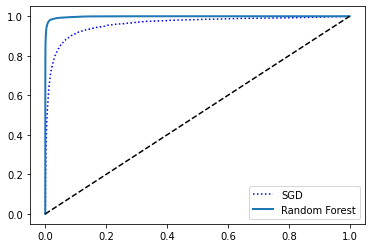

In [50]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

#### ROC AUC score, Precision score & Recall score are all impressive for RandomForestClassifier

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [52]:
y_train_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [53]:
precision_score(y_train_5, y_train_forest)

0.9905083315756169

In [54]:
recall_score(y_train_5, y_train_forest)

0.8662608374838591

## Multinomial Classifiers

### Support Vector Machine classifier

In [55]:
from sklearn.svm import SVC
svm_clf = SVC()

In [56]:
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([2], dtype=uint8)

#### The highest score is high for the some_digit value which is 2
It returns 10 scores per instance as in one-versus-one strategy instead of just 1 as in one-versus-rest strategy, which means one score per class.

In [57]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 2.7442516 , -0.30125634,  9.31399134,  7.26965016,  3.75753908,
         3.74771902,  0.71155138,  2.76650678,  8.2765048 ,  6.21840456]])

In [58]:
np.argmax(some_digit_scores)

2

In [59]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

* A trained classifier stores the list of target classes in its `classes_` attribute, ordered by value.
* In this case, the index of each class in the `classes_` array conveniently matches the class itself

In [60]:
svm_clf.classes_[3]

3

### Forcing sklearn to use one-versus-rest strategy for SVM classifier

In [61]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())

In [62]:
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

#### Similarly training SGD Classifier

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

#### Evaluating the classifier by cross validation

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

### Scaling the inputs using Standard Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

### Error analysis using confusion matrix

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)